In [13]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Dataset setup

In [ ]:
# Data Augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Load full dataset without transforms
dataset = datasets.ImageFolder(root='/home/yokoyama/Pig_research/Datasets/Datasets_ch02/dataset_ch02_unique_split', transform=None)
print(f'Total dataset size: {len(dataset)}')
print(f'Classes: {dataset.classes}')

# split: 70% train, 15% val, 15% test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_indices, val_indices, test_indices = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f'Train size: {len(train_indices)}, Val size: {len(val_indices)}, Test size: {len(test_indices)}')

# Assign transforms
train_dataset = torch.utils.data.Subset(datasets.ImageFolder(dataset.root, transform=train_transforms), train_indices.indices)
val_dataset = torch.utils.data.Subset(datasets.ImageFolder(dataset.root, transform=base_transform), val_indices.indices)
test_dataset = torch.utils.data.Subset(datasets.ImageFolder(dataset.root, transform=base_transform), test_indices.indices)

print('Train transforms:', train_dataset.dataset.transform)
print('Val transforms:',   val_dataset.dataset.transform)
print('Test transforms:',  test_dataset.dataset.transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=0)


Total dataset size: 200
Classes: ['mounting', 'non-mounting']
Train size: 140, Val size: 30, Test size: 30
Train transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.05, 0.05))
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456,

# Pre-trained MobileNetV2

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy
import numpy as np

In [28]:

# Load pre-trained MobileNetV2 model
print('\n=== MobileNetV2 Model ===')
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Fine-tune all layers
for param in model.parameters():
    param.requires_grad = True  # Fine-tune all layers

print('--- Original Classifier ---')
print(model.classifier)

# === Modify the classifier for 2 classes(Simple) ===
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model.last_channel, 2),
)
# === Modify the classifier for 2 classes(Complex) ===
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.2),
#     nn.Linear(model.last_channel, 256),
#     nn.ReLU(),
#     nn.Dropout(p=0.2),
#     nn.Linear(256, 2),
# )

print('--- Modified Classifier ---')
print(model.classifier)

# === Select device ===
print('\n=== Device Information ===')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f'Using device: {device}')

# === Optimizer with L2 Regularization ===
print('\n=== Optimizer Information ===')
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
print(optimizer)

# === Loss Function with Label smoothing ===
print('\n=== Loss Function Information ===')
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
print(criterion)

# === Scheduler ===
print('\n=== Scheduler Information ===')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
print(scheduler)


=== MobileNetV2 Model ===
--- Original Classifier ---
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
--- Modified Classifier ---
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

=== Device Information ===
Using device: cuda

=== Optimizer Information ===
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)

=== Loss Function Information ===
CrossEntropyLoss()

=== Scheduler Information ===


In [36]:
# === Early Stopping ===
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [37]:
# === Train function ===
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [38]:
# === Validation function ===
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# === Main Training Loop ===
# from early_stopping import EarlyStopping

num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
early_stopping = EarlyStopping(patience=5, verbose=True, path='./Models/best_mobilenet_v2.pt')

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("⚡️Early stopping!")
        break

print('✅Training complete.')

torch.save(model.state_dict(), './Models/final_mobilenet_v2.pt')


Epoch [1/30] Train Loss: 0.5553, Train Acc: 75.71% Val Loss: 0.3857, Val Acc: 93.33%
Validation loss decreased (inf --> 0.385678).  Saving model ...
Epoch [2/30] Train Loss: 0.3247, Train Acc: 95.00% Val Loss: 0.2419, Val Acc: 100.00%
Validation loss decreased (0.385678 --> 0.241907).  Saving model ...
Epoch [3/30] Train Loss: 0.2788, Train Acc: 96.43% Val Loss: 0.2427, Val Acc: 100.00%
EarlyStopping counter: 1 out of 7
Epoch [4/30] Train Loss: 0.2627, Train Acc: 96.43% Val Loss: 0.2655, Val Acc: 96.67%
EarlyStopping counter: 2 out of 7
Epoch [5/30] Train Loss: 0.2401, Train Acc: 98.57% Val Loss: 0.2397, Val Acc: 100.00%
Validation loss decreased (0.241907 --> 0.239713).  Saving model ...
Epoch [6/30] Train Loss: 0.2268, Train Acc: 100.00% Val Loss: 0.2389, Val Acc: 100.00%
Validation loss decreased (0.239713 --> 0.238931).  Saving model ...
Epoch [7/30] Train Loss: 0.2216, Train Acc: 100.00% Val Loss: 0.2377, Val Acc: 100.00%
Validation loss decreased (0.238931 --> 0.237659).  Saving 

# Non-pre-trained MobileNetV2

In [19]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import torch
from torch import nn, optim

In [41]:

# Load pre-trained MobileNetV2 model
print('\n=== MobileNetV2 Model ===')
model = models.mobilenet_v2(weights=None)

# Fine-tune all layers
for param in model.parameters():
    param.requires_grad = True  # Fine-tune all layers

print('--- Original Classifier ---')
print(model.classifier)

# === Modify the classifier for 2 classes(Simple) ===
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model.last_channel, 2),
)
# === Modify the classifier for 2 classes(Complex) ===
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.2),
#     nn.Linear(model.last_channel, 256),
#     nn.ReLU(),
#     nn.Dropout(p=0.2),
#     nn.Linear(256, 2),
# )

print('--- Modified Classifier ---')
print(model.classifier)

# === Select device ===
print('\n=== Device Information ===')
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f'Using device: {device}')

# === Optimizer with L2 Regularization ===
print('\n=== Optimizer Information ===')
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
print(optimizer)

# === Loss Function with Label smoothing ===
print('\n=== Loss Function Information ===')
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
print(criterion)

# === Scheduler ===
print('\n=== Scheduler Information ===')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
print(scheduler)


=== MobileNetV2 Model ===
--- Original Classifier ---
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
--- Modified Classifier ---
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

=== Device Information ===
Using device: cuda:1

=== Optimizer Information ===
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)

=== Loss Function Information ===
CrossEntropyLoss()

=== Scheduler Information ===


In [35]:
# Data Augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Load full dataset without transforms
dataset = datasets.ImageFolder(root='/home/yokoyama/Pig_research/Datasets/Datasets_ch02/dataset_ch02_unique_split', transform=None)
print(f'Total dataset size: {len(dataset)}')
print(f'Classes: {dataset.classes}')

# split: 70% train, 15% val, 15% test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_indices, val_indices, test_indices = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
print(f'Train size: {len(train_indices)}, Val size: {len(val_indices)}, Test size: {len(test_indices)}')

# Assign transforms
train_dataset = torch.utils.data.Subset(datasets.ImageFolder(dataset.root, transform=train_transforms), train_indices.indices)
val_dataset = torch.utils.data.Subset(datasets.ImageFolder(dataset.root, transform=base_transform), val_indices.indices)
test_dataset = torch.utils.data.Subset(datasets.ImageFolder(dataset.root, transform=base_transform), test_indices.indices)

print('Train transforms:', train_dataset.dataset.transform)
print('Val transforms:',   val_dataset.dataset.transform)
print('Test transforms:',  test_dataset.dataset.transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=0)


Total dataset size: 200
Classes: ['mounting', 'non-mounting']
Train size: 140, Val size: 30, Test size: 30
Train transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.05, 0.05))
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456,

In [42]:
# === Main Training Loop ===
# from early_stopping import EarlyStopping

num_epochs = 10
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
early_stopping = EarlyStopping(patience=5, verbose=True, path='./Models/best_non-pre_mobilenet_v2.pt')

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("⚡️Early stopping!")
        break

print('✅Training complete.')

torch.save(model.state_dict(), './Models/final_non-pre_mobilenet_v2.pt')


Epoch [1/10] Train Loss: 0.6832, Train Acc: 55.71% Val Loss: 0.6928, Val Acc: 53.33%
Validation loss decreased (inf --> 0.692808).  Saving model ...
Epoch [2/10] Train Loss: 0.7001, Train Acc: 48.57% Val Loss: 0.6916, Val Acc: 53.33%
Validation loss decreased (0.692808 --> 0.691630).  Saving model ...
Epoch [3/10] Train Loss: 0.7041, Train Acc: 55.00% Val Loss: 0.6914, Val Acc: 53.33%
Validation loss decreased (0.691630 --> 0.691413).  Saving model ...
Epoch [4/10] Train Loss: 0.6800, Train Acc: 56.43% Val Loss: 0.6938, Val Acc: 46.67%
EarlyStopping counter: 1 out of 5
Epoch [5/10] Train Loss: 0.6909, Train Acc: 55.71% Val Loss: 0.6942, Val Acc: 46.67%
EarlyStopping counter: 2 out of 5
Epoch [6/10] Train Loss: 0.6938, Train Acc: 54.29% Val Loss: 0.6929, Val Acc: 56.67%
EarlyStopping counter: 3 out of 5
Epoch [7/10] Train Loss: 0.6946, Train Acc: 53.57% Val Loss: 0.6924, Val Acc: 50.00%
EarlyStopping counter: 4 out of 5
Epoch [8/10] Train Loss: 0.6953, Train Acc: 51.43% Val Loss: 0.6905

16


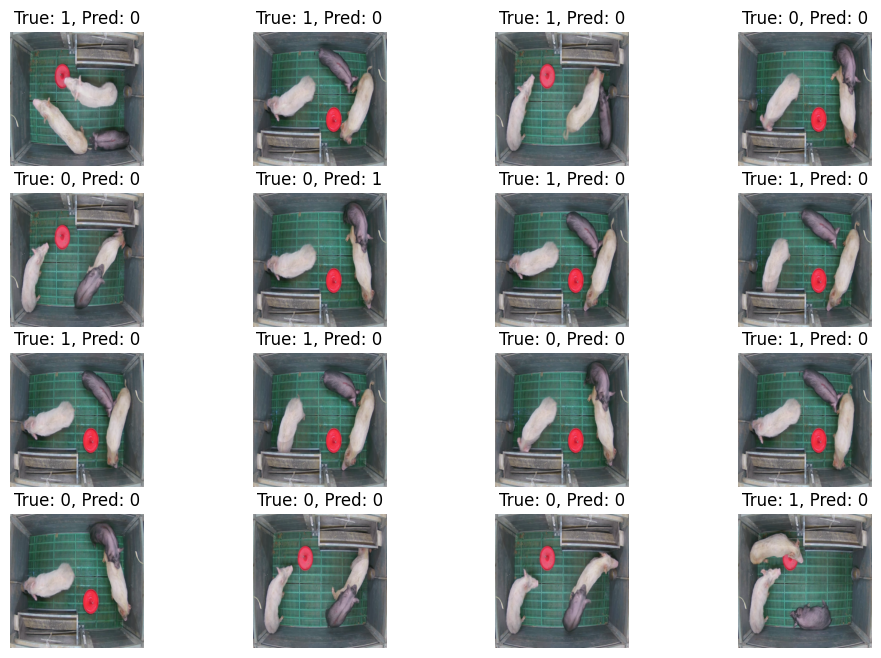

Test Accuracy: 37.50%


In [ ]:
from matplotlib import pyplot as plt
# test the model
model.load_state_dict(torch.load('./Models/best_non-pre_mobilenet_v2.pt'))
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
correct, total = 0, 0

# plot images with predictions
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    correct += (predicted == labels).sum()  # count correct predictions
    total += labels.size  # count total predictions
    
    fig = plt.figure(figsize=(12, 8))
    for i in range(min(len(images), 16)):
        ax = fig.add_subplot(4, 4, i+1)
        img = images[i].transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'True: {labels[i]}, Pred: {predicted[i]}')
        ax.axis('off')
    plt.show()
    break  # only show one batch

print(f'Test Accuracy: {100 * correct / total:.2f}%')


# Tiny ResNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet9(nn.Module):
    def __init__(self, num_classes=2, p_dropout=0.3):
        super().__init__()
        # conv1
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # conv2
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # residual block 1
        self.res1 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
        )
        self.dropout1 = nn.Dropout2d(p=p_dropout)  # 畳み込み後のDropout

        # conv3
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(p=p_dropout)

        # conv4
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # residual block 2
        self.res2 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
        )
        self.dropout3 = nn.Dropout2d(p=p_dropout)

        # fc
        self.fc = nn.Linear(512, num_classes)
        self.dropout_fc = nn.Dropout(p=p_dropout)  # 全結合層前

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.pool1(out)
        out = self.res1(out) + out
        out = self.dropout1(out)

        out = F.relu(self.bn3(self.conv3(out)))
        out = self.pool2(out)
        out = self.dropout2(out)

        out = F.relu(self.bn4(self.conv4(out)))
        out = self.pool3(out)
        out = self.res2(out) + out
        out = self.dropout3(out)

        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.dropout_fc(out)
        out = self.fc(out)
        return out


In [78]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = SimpleResNet9(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

scheduled_lr = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total * 100

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    val_loss /= val_total
    val_acc = val_correct / val_total * 100

    scheduled_lr.step()


    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Loss: {train_loss:.4f}, LR: {scheduled_lr.get_last_lr()[0]:.6f}")

torch.save(model.state_dict(), "./Models/resnet9_binary.pth")


print('✅Training complete.')
print('model saved at ./Models/resnet9_binary.pth')


Epoch [1/10], Train Acc: 47.86%, Val Acc: 53.33%, Loss: 1.3462, LR: 0.000976
Epoch [2/10], Train Acc: 53.57%, Val Acc: 46.67%, Loss: 0.7626, LR: 0.000905
Epoch [3/10], Train Acc: 65.71%, Val Acc: 83.33%, Loss: 0.6392, LR: 0.000794
Epoch [4/10], Train Acc: 64.29%, Val Acc: 73.33%, Loss: 0.6080, LR: 0.000655
Epoch [5/10], Train Acc: 66.43%, Val Acc: 70.00%, Loss: 0.6243, LR: 0.000500
Epoch [6/10], Train Acc: 70.71%, Val Acc: 53.33%, Loss: 0.6031, LR: 0.000345
Epoch [7/10], Train Acc: 73.57%, Val Acc: 60.00%, Loss: 0.5818, LR: 0.000206
Epoch [8/10], Train Acc: 67.86%, Val Acc: 63.33%, Loss: 0.6028, LR: 0.000095
Epoch [9/10], Train Acc: 71.43%, Val Acc: 63.33%, Loss: 0.6079, LR: 0.000024
Epoch [10/10], Train Acc: 72.86%, Val Acc: 63.33%, Loss: 0.5436, LR: 0.000000
✅Training complete.
model saved at ./Models/resnet9_binary.pth


In [73]:
print('Labels')
print(dataset.classes)
print('mounting:0 non-mounting:1')

Labels
['mounting', 'non-mounting']
mounting:0 non-mounting:1


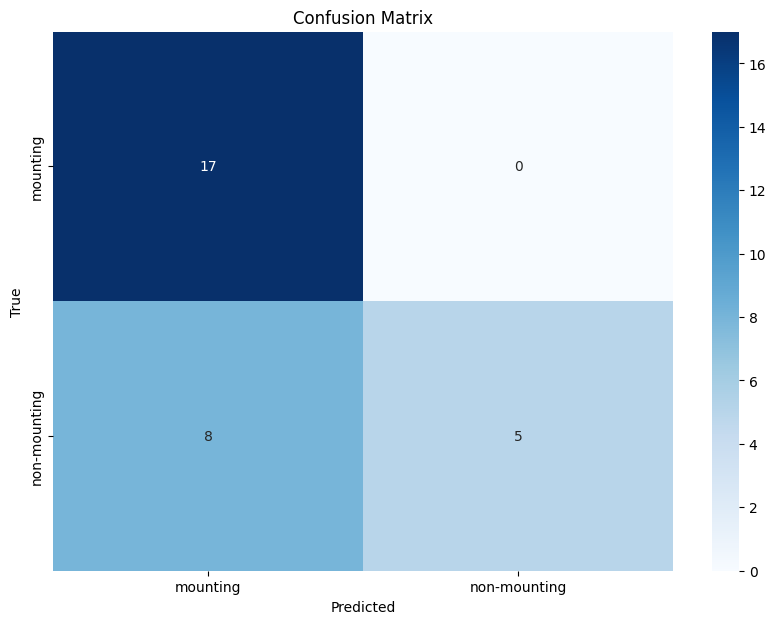

Test Accuracy: 73.33%


In [79]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

all_labels = []
all_preds = []

model.load_state_dict(torch.load("./Models/resnet9_binary.pth"))
model.eval()
model = model.to(device)

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)


plt.figure(figsize=(10, 7))
# 0: mounting, 1: non-mounting
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['mounting', 'non-mounting'], yticklabels=['mounting', 'non-mounting'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels) * 100
print(f'Test Accuracy: {accuracy:.2f}%')

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(predicted.cpu().numpy())


# K-Fold Cross Validation   

In [60]:
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import numpy as np

In [61]:
# K-Fold設定（例：5分割）
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 結果を記録
results = {}

In [62]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f'\n===== Fold {fold+1} / {k_folds} =====')
    print(f'Train: {len(train_idx)} | Val: {len(val_idx)}')

    # データ分割
    train_subset = Subset(dataset, train_idx)
    val_subset   = Subset(dataset, val_idx)

    # DataLoader作成
    train_subset.dataset.transform = train_transforms
    val_subset.dataset.transform   = base_transform

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_subset, batch_size=16, shuffle=False)

    # MobileNetV2の新しいインスタンスを作成
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = True  # 全層をファインチューニング
    model.classifier[1] = nn.Linear(model.last_channel, 2)
    model = model.to(device)

    # 損失関数・最適化・スケジューラ
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

    early_stopping = EarlyStopping(patience=5, verbose=False, path=f'fold{fold+1}_best.pt')

    num_epochs = 50
    best_val_acc = 0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()

        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        best_val_acc = max(best_val_acc, val_acc)

    # 保存した最良モデルをロード
    model.load_state_dict(torch.load(f'fold{fold+1}_best.pt'))

    # 検証データの最終評価
    _, final_val_acc = validate(model, val_loader, criterion, device)
    results[fold] = final_val_acc



===== Fold 1 / 5 =====
Train: 160 | Val: 40


/home/yokoyama/Pig_research/pig_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yokoyama/Pig_research/pig_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50] - Train Acc: 81.88%, Val Acc: 95.00%
Epoch [2/50] - Train Acc: 97.50%, Val Acc: 97.50%
Epoch [3/50] - Train Acc: 98.75%, Val Acc: 100.00%
Epoch [4/50] - Train Acc: 100.00%, Val Acc: 100.00%
Epoch [5/50] - Train Acc: 100.00%, Val Acc: 100.00%
Epoch [6/50] - Train Acc: 100.00%, Val Acc: 100.00%
EarlyStopping counter: 1 out of 7
Epoch [7/50] - Train Acc: 100.00%, Val Acc: 100.00%
Epoch [8/50] - Train Acc: 100.00%, Val Acc: 100.00%
Epoch [9/50] - Train Acc: 100.00%, Val Acc: 100.00%
Epoch [10/50] - Train Acc: 100.00%, Val Acc: 100.00%
Epoch [11/50] - Train Acc: 100.00%, Val Acc: 100.00%
Epoch [12/50] - Train Acc: 100.00%, Val Acc: 100.00%
EarlyStopping counter: 1 out of 7
Epoch [13/50] - Train Acc: 100.00%, Val Acc: 100.00%
EarlyStopping counter: 2 out of 7
Epoch [14/50] - Train Acc: 100.00%, Val Acc: 100.00%
EarlyStopping counter: 3 out of 7
Epoch [15/50] - Train Acc: 100.00%, Val Acc: 100.00%
EarlyStopping counter: 4 out of 7
Epoch [16/50] - Train Acc: 100.00%, Val Acc: 100.

In [63]:
print("\nK-Fold Cross Validation Results:")
sum_acc = 0.0
for fold in range(k_folds):
    print(f'Fold {fold+1}: {results[fold]:.2f}%')
    sum_acc += results[fold]
print(f'Average Accuracy: {sum_acc / k_folds:.2f}%')



K-Fold Cross Validation Results:
Fold 1: 100.00%
Fold 2: 100.00%
Fold 3: 100.00%
Fold 4: 92.50%
Fold 5: 97.50%
Average Accuracy: 98.00%


In [11]:
import os
from glob import glob

all_files = glob('../../Datasets/Datasets_ch02/dataset_ch02_unique/*.png', recursive=True)
print(f"Unique file count: {len(set(all_files))}, Total: {len(all_files)}")

Unique file count: 200, Total: 200


In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import torch

# データ前処理（MobileNetV2の入力に合わせる）
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# データセット全体を読み込み
dataset_path = "/home/yokoyama/Pig_research/Datasets/Datasets_ch02/dataset_ch02_unique_split"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

print(f"Total samples: {len(dataset)}")
print(f"Classes: {dataset.classes}")


Total samples: 200
Classes: ['mounting', 'non-mounting']
